<a href="https://colab.research.google.com/github/nlee98/ADS-504-Machine-Learning-in-Python/blob/main/ADS_504_Team_Project_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS-504 Final Team Project #

This project aims to construct a pipeline for accurately predicting the median value of a home in California, given census data from 1990. While the data set may be out of date, the method developed here can act as a foundation for modern home value estimations given up-to-date data.

```
To save to GitHub, Click *File* and "Save a copy in GitHub", then save to the team repository 
```

In [ ]:
## Load in Packages ##
from scipy.stats import skew
from math import sqrt
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import \
  train_test_split, cross_val_score, KFold, \
  GridSearchCV, cross_validate, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load in Data Set ##

In [ ]:
# Load in Data #
## Upload housing.csv from device ##
#uploaded = files.upload()

In [ ]:
## Convert housing.csv to a Data Frame ##
# I prefer to pull the data directly from github. 
# To do this I need to go to the raw data screen in github and get the latest token value.
house_df = pd.read_csv("/content/housing.csv")

## General Exploratory Data Analysis ##
Dimensions, first 5 rows, number of missing values, etc.

In [ ]:
house_df.shape

(20640, 10)

In [ ]:
house_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Null Value Count ####

In [ ]:
house_df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### Summary Statistics ####

In [ ]:
house_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Distribution of Features ###

#### Histogram Distributions of Numerical Features ####

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d81c913d0>,
      dtype=object)

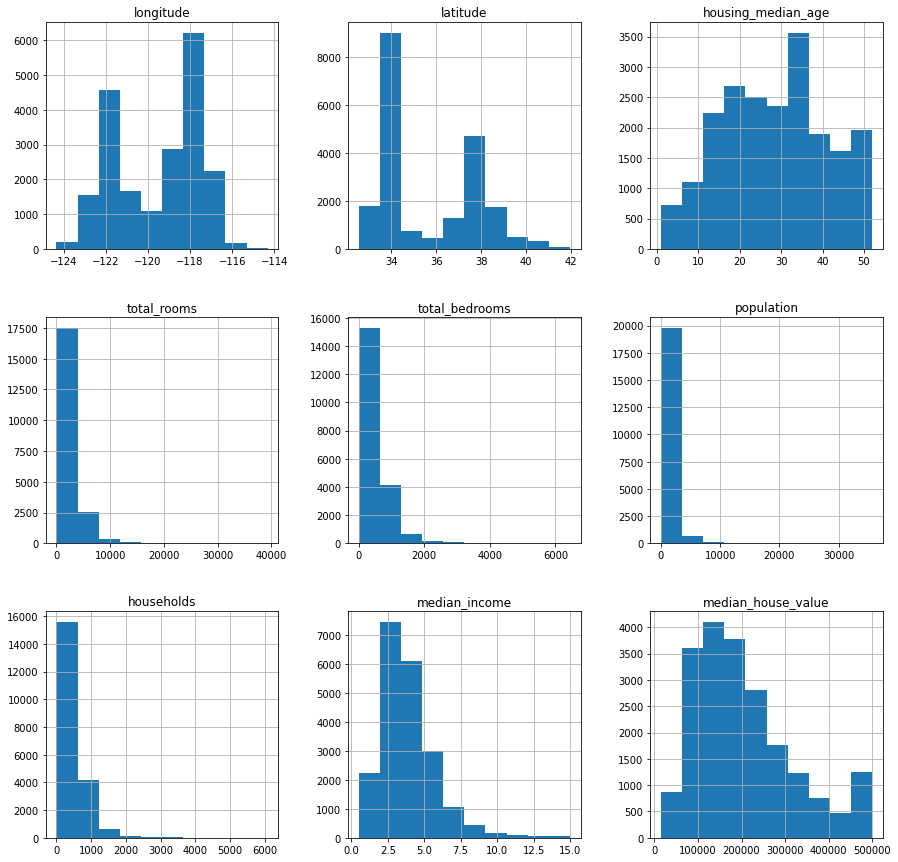

In [ ]:
house_df.hist(figsize = (15, 15))

The features latitude, total_rooms, total_bedrooms, population, households, median_income, and median_house_value are skewed right.

#### Box and Whisker Plots of Each Feature ####
Plots will show if any outliers are present

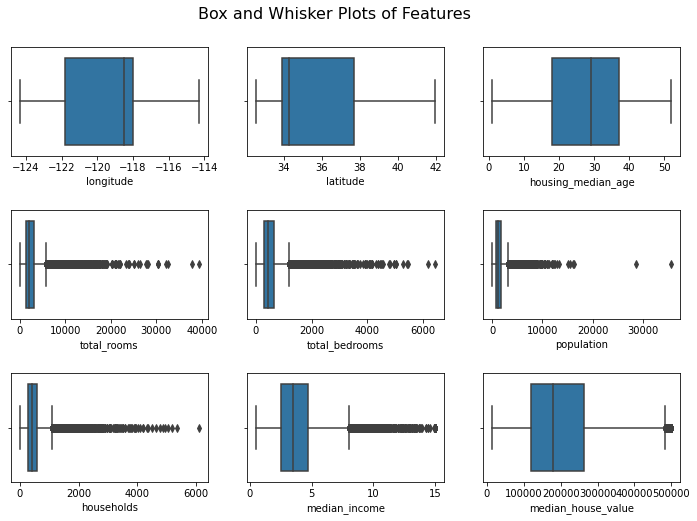

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Box and Whisker Plots of Features", fontsize = 16, y = 0.95)

feat = house_df.columns.tolist()
# Remove Categorical Feature #
feat.remove("ocean_proximity")

for n, feature in enumerate(feat):
  ax = plt.subplot(3, 3, n + 1)
  sns.boxplot(house_df[feature], ax = ax)


#### Distribution of Categorical Feature - ocean_proximity ####

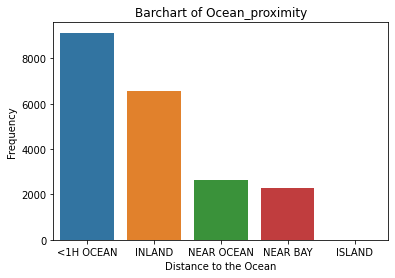

In [ ]:
ocean_prox = pd.DataFrame(house_df["ocean_proximity"].value_counts())
ocean_prox["Distance"] = ocean_prox.index
sns.barplot(ocean_prox["Distance"], ocean_prox["ocean_proximity"])
plt.xlabel("Distance to the Ocean")
plt.ylabel("Frequency")
plt.title("Barchart of Ocean_proximity")
plt.show()

#### Correlation Matrix ####

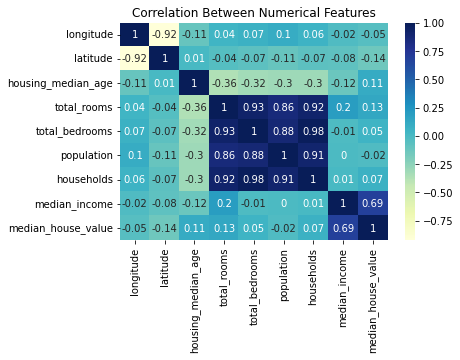

In [ ]:
numerical_feat = house_df.iloc[:, :-1]
corr_values = round(numerical_feat.corr(),2)
sns.heatmap(corr_values, annot = True, cmap="YlGnBu")
plt.title("Correlation Between Numerical Features")
plt.show()

The four features that are strongly correlated with one another are total_rooms, total_bedrooms, population, and households.

There is also a strong correlation between latitude and longitude and a moderately strong correlation between median_income and the target feature, median_house_value.

## Pre-Processing ##

### Removing Missing Values ###
The 207 records missing values values for total_bedrooms will be removed. According to Mears et al. (n.d.), if missing value makes up less than 5% of the data, it is acceptable to remove the missing values.

**Reference**

Mears, K., Montelpare, W. J., Read, E., McComber, T., Mahar, A., & Ritchie, K. (n.d.). Working with missing data. Applied Statistics in Healthcare Research. Retrieved July 27, 2022, from https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/#:~:text=How%20much%20data%20is%20missing%3F,to%20which%20data%20is%20missing. 

In [ ]:
house_df_completecases = house_df.dropna()
# house_df_completecases.isnull().sum()

### K-Means Cluster Latitude/Longitude ###
K-means clustering has been used historically to create homogenous regions based on geographic features, such as longitude and latitude. Novianti et al. (2017) used K-means clustering to predict the magnitude of earthquakes, given a data set that contained longitude and latitude as predictors. Similarly, Arora (2017) used longitude and latitude to group users by location to predict for cellular activity.

K of 58 is used to represent the 58 counties in San Diego (Senate Governance and Finance Committee, 2016). Using K = 58 will mitigate the increase in dimensionality when encoding clusters to categories.

**References**

Arora, S. (2017). Analyzing mobile phone usage using clustering in Spark MLLib and Pig. *International Journal of Advanced Research in Computer Science, 8*(1).

Novianti, P., Setyorini, D., & Rafflesia, U. (2017). K-Means cluster analysis in earthquake epicenter clustering. *International Journal of Advances in Intelligent Informatics, 3*(2), 81-89.

Senate Governance and Finance Committee. (2016). *COUNTY FACT SHEET*. https://sgf.senate.ca.gov/sites/sgf.senate.ca.gov/files/county_facts_2016.pdf

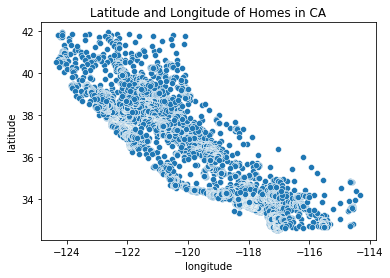

Correlation Between Latitude and Longitude:  -0.924664433915041


In [ ]:
# Plot of Latitude and Longitude #
## Latitude - Position North and South ##
## Longitude - Position East and West ##
sns.scatterplot(x = house_df["longitude"], 
                y = house_df["latitude"])
plt.title("Latitude and Longitude of Homes in CA")
plt.show()
print("Correlation Between Latitude and Longitude: ",
      house_df["longitude"].corr(house_df["latitude"]))

The variables latitude and longitude are strongly correlated. Because each pair of points represents a geographical location, clustering will be utilized to extract an (estimated) neighborhood/region feature.

In [ ]:
lat_and_long = house_df_completecases[["longitude", "latitude"]]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=58, random_state = 50)
kmeans.fit(lat_and_long)
y_kmeans = kmeans.predict(lat_and_long)

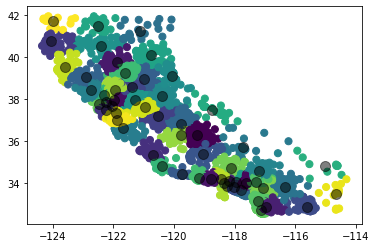

In [ ]:
plt.scatter(lat_and_long["longitude"], lat_and_long["latitude"], 
            c = y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
# Centers: [longitude, latitude]
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', 
            s = 100, alpha=0.5);

Treat the assigned cluster number as a hypothetical county number. Also, because the county number is representative of longitude and latitude, longitude and latitude can be removed.

In [ ]:
house_df_withcluster = house_df_completecases
house_df_withcluster["CountyNumber"] = y_kmeans
house_df_withcluster["CountyNumber"] = house_df_withcluster[
    "CountyNumber"].astype(str)
# house_df_withcluster.head(20)

In [ ]:
# Drop Latitude and Longitude #
house_df_withcluster = house_df_withcluster.drop(
    ["longitude", "latitude"], axis = 1)
# Convert The Number to String - to treat as a category #
house_df_withcluster.head(3)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,CountyNumber
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,7
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,7
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,7


### One Hot Encode ###

In [ ]:
# Identify Categorical Features
categorical_feat = ["ocean_proximity", "CountyNumber"]

cat_encoder = ColumnTransformer(
    [('encoder', OneHotEncoder(), categorical_feat)])
encoded_matrix = cat_encoder.fit_transform(house_df_withcluster)

feat_names = cat_encoder.get_feature_names()

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_matrix,
                columns = feat_names)

In [ ]:
# Add Encoded Features to the DataFrame #
house_encoded_df = house_df_withcluster.reset_index(drop=True).merge(
    encoded_df.reset_index(drop=True), 
    left_index=True, right_index=True)

# Drop Original Categorical Variables #
## Capital X for model ready train and test sets ##
house_df_modelready = house_encoded_df.drop(["ocean_proximity", "CountyNumber"], axis = 1)

In [ ]:
house_df_modelready

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,encoder__x0_<1H OCEAN,encoder__x0_INLAND,encoder__x0_ISLAND,...,encoder__x1_52,encoder__x1_53,encoder__x1_54,encoder__x1_55,encoder__x1_56,encoder__x1_57,encoder__x1_6,encoder__x1_7,encoder__x1_8,encoder__x1_9
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20428,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20429,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20430,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20431,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Test Split ##

In [ ]:
# Split Predictors from Target Feature #
x_data = house_df_modelready.loc[
    :, house_df_modelready.columns != "median_house_value"]
y_data = house_df_modelready[["median_house_value"]]

# Distinguish Numerical Variables #
numerical_feat = house_df_modelready.iloc[:, :7].columns
numerical_feat = numerical_feat.drop("median_house_value")

# Split Data 
xtrain, xtest, ytrain, ytest = train_test_split(
    x_data, y_data, test_size = 0.3, random_state = 50)

### Pipeline Construction ###
One pipeline is built to remove near-zero variance predictors and center and scale numerical features.

Another pipeline utilizes one-hot encoding to encode categorical features,  ocean_proximity and CountyNumber. 

#### Feature Pipelines ####

In [ ]:
# Numerical Pipeline:
## 1) Removes Near Zero Variance Predictors
## 2) Centers and Scales the Features 
numerical_pipeline = Pipeline([("zerovariance", VarianceThreshold()),
                                        ("scaler", StandardScaler())])

# PCA Pipeline for Numerical Features:
pca_pipeline = Pipeline([("pca", PCA(n_components = 2))])

# Categorical Pipeline
## Performs one-hot encoding on categorical features
# categorical_pipeline = Pipeline([("onehotencoder", OneHotEncoder())])

#### Model Pipelines ####

##### Linear Regression #####
Since it is the most simple of the regression models, a multiple linear regression model will act as the baseline model for this study.

The below chunk is without PCA.

In [ ]:
# Linear Regression Pipeline #
linear_reg_preprocess = make_pipeline(ColumnTransformer([
    ("num", numerical_pipeline, numerical_feat)], remainder = "passthrough"))
linear_reg_preprocess2 = make_pipeline(LinearRegression())

# Pre-Process Training Data #
linear_reg_train1 = linear_reg_preprocess.fit_transform(xtrain)
transformed_df = pd.DataFrame(linear_reg_train1)
#print(transformed_df.shape)

## Columns are ordered, thus principle components are the last columns 6 and 7 ##
## Keep columns 6:end ##
#linear_reg_df = testdf.iloc[:, 6:]
# Train Linear Model #
linear_reg_model = linear_reg_preprocess2.fit(transformed_df, ytrain)
print("Training Metrics: ")
print("Coefficient of Determination (R^2): ", 
      linear_reg_model.score(transformed_df, ytrain).round(4))
print("Mean Squared Error (MSE): ",
      mean_squared_error(
      ytrain, linear_reg_model.predict(transformed_df)).round(4))
print("Root Mean Square Error (RMSE): ",
      sqrt(mean_squared_error(
      ytrain, linear_reg_model.predict(transformed_df)).round(4)), "\n")
#print(transformed_df.shape)

# Preprocess Test Data #
linear_reg_test_preproc1 = linear_reg_preprocess.transform(xtest)

test_data_preproc_df = pd.DataFrame(linear_reg_test_preproc1)
#print(test_data_preproc_df.shape)
#linear_reg_test_df = test_data_preproc_df.iloc[:, 6:]
#print(linear_reg_test_df.shape)

#Predict Train Data
linear_reg_train_pred = linear_reg_model.predict(transformed_df)

# Fit trained model and predict test data #
linear_reg_pred = linear_reg_model.predict(test_data_preproc_df)
print("Test Metrics:")
print("Coefficient of Determination (R^2): ", 
        r2_score(ytest, linear_reg_pred).round(4))
print("Mean Squared Error (MSE): ",
      mean_squared_error(
      ytest, linear_reg_pred).round(4))
print("Root Mean Square Error (RMSE): ",
      sqrt(mean_squared_error(
      ytest, linear_reg_pred)), "\n")

Training Metrics: 
Coefficient of Determination (R^2):  0.7135
Mean Squared Error (MSE):  3801878023.2451
Root Mean Square Error (RMSE):  61659.37092806819 

Test Metrics:
Coefficient of Determination (R^2):  0.7169
Mean Squared Error (MSE):  3805269979.068
Root Mean Square Error (RMSE):  61686.8703945015 



The below chunk is with PCA and Cross-Validation.

In [ ]:
# Linear Regression #
## Scaler (and Near-Zero Variance) Pipeline ##
scaler_pipe = make_pipeline(ColumnTransformer([
    ("num", numerical_pipeline, numerical_feat)], remainder = "passthrough"))

# Pre-Process Training Data #
xtrain_scaled = scaler_pipe.fit_transform(xtrain)
xtrain_scaled_df = pd.DataFrame(xtrain_scaled,
                  columns = scaler_pipe.get_feature_names_out())
# Apply Scaler Pipeline to Test Data #
xtest_scaled = scaler_pipe.transform(xtest)
xtest_scaled_df = pd.DataFrame(xtest_scaled,
                  columns = scaler_pipe.get_feature_names_out())

## PCA pipeline ##
num_features = list(xtrain_scaled_df.filter(regex="num_").columns)
pca_pipe = make_pipeline(ColumnTransformer([
    ("pca", pca_pipeline, num_features)], remainder = "passthrough"))
# Apply PCA to Training Data #
xtrain_pca = pca_pipe.fit_transform(xtrain_scaled_df)
xtrain_pca_df = pd.DataFrame(xtrain_pca)
# Apply PCA to Test Data #
xtest_pca = pca_pipe.fit_transform(xtest_scaled_df)
xtest_pca_df = pd.DataFrame(xtest_pca)

## Get Feature Names ##
feature_names = list(xtrain_scaled_df.columns)[6:]
all_features = ["PC1", "PC2"]
all_features.extend(feature_names)
# Re-name Columns #
xtrain_pca_df.columns = all_features
xtest_pca_df.columns = all_features

## Cross Validation ##
linear_reg_pipe = make_pipeline(LinearRegression())
cross_val = KFold(n_splits = 10)
cv_scores = cross_validate(linear_reg_pipe, xtrain_pca_df, ytrain, 
            cv = cross_val, scoring = ["r2", "neg_mean_squared_error",
                                       "neg_root_mean_squared_error"])
print("Training Cross-Validated Metrics: ")
print("Avg. Cross-Validated R^2: ", cv_scores["test_r2"].mean().round(4))
print("Avg. Cross-Validated MSE: ", abs(cv_scores[
    "test_neg_mean_squared_error"]).mean().round(4))
print("Avg. Cross-Validated RMSE: ", abs(cv_scores[
    "test_neg_root_mean_squared_error"]).mean().round(4), "\n")

# Predict Testing Data #
linear_reg_model.fit(xtrain_pca_df, ytrain)

#PM train_pred
train_pred = linear_reg_model.predict(xtrain_pca_df)

test_pred = linear_reg_model.predict(xtest_pca_df)
print("Test Metrics: ")
print("R^2: ", r2_score(ytest, test_pred).round(4))
print("MSE: ", mean_squared_error(ytest, test_pred).round(4))
print("RMSE: ", sqrt(mean_squared_error(ytest, test_pred)))

Training Cross-Validated Metrics: 
Avg. Cross-Validated R^2:  0.6436
Avg. Cross-Validated MSE:  4723667551.2431
Avg. Cross-Validated RMSE:  68673.9186 

Test Metrics: 
R^2:  0.6565
MSE:  4617745668.0938
RMSE:  67953.99670434257


---
##### Lasso Regression Model #####
L1 Regularization

In [ ]:
# Linear Model trained with L1 prior as regularizer (aka the Lasso).

# Lasso Regression Pipeline #
lasso_pipe = make_pipeline(Lasso())

# Parameter Grid Search #
# lasso_pipe.get_params().keys() # Use this to find available hyperparameter names
lasso_params = {'lasso__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Cross-Validated Parameter Search #
lasso_gs = GridSearchCV(lasso_pipe,
                        param_grid = lasso_params,
                        scoring = "r2",
                        cv = 10,
                        return_train_score=True,)



In [ ]:
# Using Non-PCA data
# Predict Testing Data #
lasso_fit = lasso_gs.fit(transformed_df, ytrain)

# Get Training Results
lasso_results = lasso_fit.cv_results_

#PM:
#Predict Training Set
lasso_train_pred = lasso_fit.predict(transformed_df)

# Predict Test Set
lasso_test_pred = lasso_fit.predict(test_data_preproc_df)

# Display training results
def training_results(model_fit):
  print(" Results from Grid Search: " )
  print("\n The best estimator across ALL searched params:\n",model_fit.best_estimator_)
  print("\n The best score across ALL searched params:\n",model_fit.best_score_)
  print("\n The best parameters across ALL searched params:\n",model_fit.best_params_)

training_results(lasso_fit)

## Test Prediction Results ##
def test_results(ypred):
  rsq = r2_score(ytest, ypred).round(4)
  mae = mean_absolute_error(ytest, ypred).round(4)
  mse = mean_squared_error(ytest, ypred).round(4)
  rmse = np.sqrt(mean_squared_error(ytest, ypred)).round(4)
  print("\n Test Metrics: ")
  print(f' Coefficient of Determination (R^2): {rsq:.2f}')
  print(f' Mean absolute error (MAE): {mae:.2f}')
  print(f' Mean squared error (MSE): {mse:.2f}')
  print(f' Root mean squared error (RMSE): {rmse:.2f}\n')

test_results(lasso_test_pred)

# Hyperparameter Results
def hp_results(cv_results):
  results_df = pd.DataFrame(cv_results)
  results_df = results_df.sort_values(by=["rank_test_score"])
  results_df = results_df.set_index(
      results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
      ).rename_axis("param combo")
  return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

hp_results(lasso_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('lasso', Lasso(alpha=1))])

 The best score across ALL searched params:
 0.7088012816788359

 The best parameters across ALL searched params:
 {'lasso__alpha': 1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.72
 Mean absolute error (MAE): 43876.42
 Mean squared error (MSE): 3805630466.51
 Root mean squared error (RMSE): 61689.79



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
1,{'lasso__alpha': 1},1,0.708801,0.018267
0.1,{'lasso__alpha': 0.1},2,0.708800,0.018261
0.01,{'lasso__alpha': 0.01},3,0.708799,0.018261
0.001,{'lasso__alpha': 0.001},4,0.708799,0.018261
0.0001,{'lasso__alpha': 0.0001},5,0.708799,0.018261
1e-05,{'lasso__alpha': 1e-05},6,0.708799,0.018261
10,{'lasso__alpha': 10},7,0.708689,0.018378
100,{'lasso__alpha': 100},8,0.701197,0.018307
1000,{'lasso__alpha': 1000},9,0.660635,0.018031


In [ ]:
# Using PCA data

# Predict Testing Data #
lasso_pca_fit = lasso_gs.fit(xtrain_pca_df, ytrain)

# Get Training Results
lasso_pca_results = lasso_pca_fit.cv_results_

# Predict Train Set
lasso_pca_train_pred = lasso_pca_fit.predict(xtrain_pca_df)

# Predict Test Set
lasso_pca_test_pred = lasso_pca_fit.predict(xtest_pca_df)

# Display training results
training_results(lasso_pca_fit)

## Test Prediction Results ##
test_results(lasso_pca_test_pred)

# Hyperparameter Results
hp_results(lasso_pca_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('lasso', Lasso(alpha=0.1))])

 The best score across ALL searched params:
 0.6502119259290915

 The best parameters across ALL searched params:
 {'lasso__alpha': 0.1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.66
 Mean absolute error (MAE): 49354.53
 Mean squared error (MSE): 4617727398.24
 Root mean squared error (RMSE): 67953.86



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
0.1,{'lasso__alpha': 0.1},1,0.650212,0.016611
0.01,{'lasso__alpha': 0.01},2,0.650212,0.016609
0.001,{'lasso__alpha': 0.001},3,0.650212,0.016609
0.0001,{'lasso__alpha': 0.0001},4,0.650212,0.016609
1e-05,{'lasso__alpha': 1e-05},5,0.650212,0.016609
1,{'lasso__alpha': 1},6,0.650210,0.016628
10,{'lasso__alpha': 10},7,0.650018,0.016838
100,{'lasso__alpha': 100},8,0.641378,0.018420
1000,{'lasso__alpha': 1000},9,0.585032,0.020291


---
##### Ridge Regression #####
L2 Regularization

In [ ]:
# Linear least squares with l2 regularization.

# Ridge Regression Pipeline #
ridge_pipe = make_pipeline(Ridge())

# Parameter Grid Search #
# ridge_pipe.get_params().keys() # Use this to find available hyperparameter names
parameter_grid = {
    "ridge__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Cross-Validated Parameter Search #
ridge_gs = GridSearchCV(ridge_pipe,
                        param_grid = parameter_grid,
                        scoring = "r2",
                        cv = 10,
                        return_train_score=True,)


In [ ]:
# Using Non-PCA data
# Predict Testing Data #
ridge_fit = ridge_gs.fit(transformed_df, ytrain)

# Get Training Results
ridge_results = ridge_fit.cv_results_

#Predict Train Set
ridge_train_pred = ridge_fit.predict(transformed_df)

# Predict Test Set
ridge_test_pred = ridge_fit.predict(test_data_preproc_df)

# Display training results
training_results(ridge_fit)

## Test Prediction Results ##
test_results(ridge_test_pred)

# Hyperparameter Results
hp_results(ridge_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('ridge', Ridge(alpha=0.1))])

 The best score across ALL searched params:
 0.7088051470141989

 The best parameters across ALL searched params:
 {'ridge__alpha': 0.1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.72
 Mean absolute error (MAE): 43876.66
 Mean squared error (MSE): 3805289499.32
 Root mean squared error (RMSE): 61687.03



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
0.1,{'ridge__alpha': 0.1},1,0.708805,0.018271
0.01,{'ridge__alpha': 0.01},2,0.708800,0.018262
0.001,{'ridge__alpha': 0.001},3,0.708799,0.018261
0.0001,{'ridge__alpha': 0.0001},4,0.708799,0.018261
1e-05,{'ridge__alpha': 1e-05},5,0.708799,0.018261
1,{'ridge__alpha': 1},6,0.708790,0.018363
10,{'ridge__alpha': 10},7,0.707122,0.018697
100,{'ridge__alpha': 100},8,0.694502,0.018112
1000,{'ridge__alpha': 1000},9,0.652298,0.019623


In [ ]:
# Using PCA data
# Predict Testing Data #
ridge_pca_fit = ridge_gs.fit(xtrain_pca_df, ytrain)

# Get Training Results
ridge_pca_results = ridge_pca_fit.cv_results_

#Predict Train Set
ridge_pca_train_pred = ridge_pca_fit.predict(xtrain_pca_df)

# Predict Test Set
ridge_pca_test_pred = ridge_pca_fit.predict(xtest_pca_df)

# Display training results
training_results(ridge_pca_fit)

## Test Prediction Results ##
test_results(ridge_pca_test_pred)

# Hyperparameter Results
hp_results(ridge_pca_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('ridge', Ridge(alpha=0.1))])

 The best score across ALL searched params:
 0.6502157786788072

 The best parameters across ALL searched params:
 {'ridge__alpha': 0.1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.66
 Mean absolute error (MAE): 49353.26
 Mean squared error (MSE): 4617578914.53
 Root mean squared error (RMSE): 67952.77



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
0.1,{'ridge__alpha': 0.1},1,0.650216,0.016627
0.01,{'ridge__alpha': 0.01},2,0.650212,0.016611
0.001,{'ridge__alpha': 0.001},3,0.650212,0.016609
0.0001,{'ridge__alpha': 0.0001},4,0.650212,0.016609
1e-05,{'ridge__alpha': 1e-05},5,0.650212,0.016609
1,{'ridge__alpha': 1},6,0.650165,0.016769
10,{'ridge__alpha': 10},7,0.647661,0.017540
100,{'ridge__alpha': 100},8,0.628123,0.018751
1000,{'ridge__alpha': 1000},9,0.555309,0.021703


---
##### Elastic Net Model #####
L1 and L2 Regularization

In [ ]:
# Linear regression with combined L1 and L2 priors as regularizer.

# Elastic Net Regression Pipeline #
# enet Regression Pipeline #
enet_pipe = make_pipeline(ElasticNet())

# Parameter Grid Search #
# enet_pipe.get_params().keys() # Use this to find available hyperparameter names
parameter_grid = {
    "elasticnet__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "elasticnet__l1_ratio": [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}

# For l1_ratio = 0 the penalty is an L2 penalty. L2 regularization penalizes the sum of squares of the weights.
# For l1_ratio = 1 it is an L1 penalty. L1 regularization penalizes the sum of absolute values of the weights.

# Cross-Validated Parameter Search #
enet_gs = GridSearchCV(enet_pipe,
                       param_grid = parameter_grid,
                       scoring = "r2",
                       cv = 10,
                       return_train_score=True,)


In [ ]:
# Using Non-PCA data
# Predict Testing Data #
enet_fit = enet_gs.fit(transformed_df, ytrain)

# Get Training Results
enet_results = enet_fit.cv_results_

# Predict Train Set
enet_train_pred = enet_fit.predict(transformed_df)

# Predict Test Set
enet_test_pred = enet_fit.predict(test_data_preproc_df)

# Display training results
training_results(enet_fit)

## Test Prediction Results ##
test_results(enet_test_pred)

# Hyperparameter Results
hp_results(enet_results)


 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('elasticnet', ElasticNet(alpha=1e-05, l1_ratio=0))])

 The best score across ALL searched params:
 0.7088070645177229

 The best parameters across ALL searched params:
 {'elasticnet__alpha': 1e-05, 'elasticnet__l1_ratio': 0}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.72
 Mean absolute error (MAE): 43876.59
 Mean squared error (MSE): 3805315633.80
 Root mean squared error (RMSE): 61687.24



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
1e-05_0,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",1,0.708807,0.018276
1e-05_1e-05,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",2,0.708807,0.018276
1e-05_0.0001,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",3,0.708807,0.018276
1e-05_0.001,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",4,0.708807,0.018276
1e-05_0.01,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",5,0.708807,0.018276
...,...,...,...,...
1000_0.01,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",59,-0.000090,0.001530
1000_0.001,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",60,-0.000101,0.001530
1000_0.0001,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",61,-0.000102,0.001530


In [ ]:
# Using PCA data
# Predict Testing Data #
enet_pca_fit = enet_gs.fit(xtrain_pca_df, ytrain)

# Get Training Results
enet_pca_results = enet_pca_fit.cv_results_

#Predict Train Set
ent_pca_train_pred = enet_pca_fit.predict(xtrain_pca_df)

# Predict Test Set
enet_pca_test_pred = enet_pca_fit.predict(xtest_pca_df)

# Display training results
training_results(enet_pca_fit)

## Test Prediction Results ##
test_results(enet_pca_test_pred)

# Hyperparameter Results
hp_results(enet_pca_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('elasticnet', ElasticNet(alpha=1e-05, l1_ratio=0))])

 The best score across ALL searched params:
 0.6502163755619608

 The best parameters across ALL searched params:
 {'elasticnet__alpha': 1e-05, 'elasticnet__l1_ratio': 0}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.66
 Mean absolute error (MAE): 49352.43
 Mean squared error (MSE): 4617475400.40
 Root mean squared error (RMSE): 67952.01



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
1e-05_0,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",1,0.650216,0.016634
1e-05_1e-05,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",2,0.650216,0.016634
1e-05_0.0001,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",3,0.650216,0.016634
1e-05_0.001,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",4,0.650216,0.016634
1e-05_0.01,"{'elasticnet__alpha': 1e-05, 'elasticnet__l1_r...",5,0.650216,0.016633
...,...,...,...,...
1000_0.01,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",59,-0.000432,0.001535
1000_0.001,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",60,-0.000440,0.001535
1000_0.0001,"{'elasticnet__alpha': 1000, 'elasticnet__l1_ra...",61,-0.000440,0.001535


---
##### Boosted Trees Model #####

In [ ]:
# Gradient Boosting for regression.

# Gradient Boosting Regression Pipeline #
# gbr Regression Pipeline #
gbr_pipe = make_pipeline(GradientBoostingRegressor())

# Parameter Grid Search #
# gbr_pipe.get_params().keys() # Use this to find available hyperparameter names
parameter_grid = {'gradientboostingregressor__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  # 'gradientboostingregressor__subsample': [0.9, 0.5, 0.2, 0.1],
                  # 'gradientboostingregressor__n_estimators': [100, 500, 1000, 1500],
                  # 'gradientboostingregressor__max_depth': [4, 6, 8, 10]
                  }

# Cross-Validated Parameter Search #
gbr_gs = GridSearchCV(gbr_pipe,
                      param_grid = parameter_grid,
                      scoring = "r2",
                      cv = 10,
                      return_train_score=True, 
                      n_jobs=-1)


In [ ]:
# Using Non-PCA data
# Predict Testing Data #
gbr_fit = gbr_gs.fit(transformed_df, ytrain)

# Get Training Results
gbr_results = gbr_fit.cv_results_

# Predict Training Set
gbr_train_pred = gbr_fit.predict(transformed_df)

# Predict Test Set
gbr_test_pred = gbr_fit.predict(test_data_preproc_df)

# Display training results
training_results(gbr_fit)

## Test Prediction Results ##
test_results(gbr_test_pred)

# Hyperparameter Results
hp_results(gbr_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('gradientboostingregressor', GradientBoostingRegressor())])

 The best score across ALL searched params:
 0.7421541506416929

 The best parameters across ALL searched params:
 {'gradientboostingregressor__learning_rate': 0.1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.75
 Mean absolute error (MAE): 41359.87
 Mean squared error (MSE): 3388518033.05
 Root mean squared error (RMSE): 58210.98



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
0.1,{'gradientboostingregressor__learning_rate': 0.1},1,7.421542e-01,0.015085
1,{'gradientboostingregressor__learning_rate': 1},2,7.414322e-01,0.013176
0.01,{'gradientboostingregressor__learning_rate': 0...,3,5.221351e-01,0.017461
0.001,{'gradientboostingregressor__learning_rate': 0...,4,1.020082e-01,0.004312
0.0001,{'gradientboostingregressor__learning_rate': 0...,5,9.995739e-03,0.001426
1e-05,{'gradientboostingregressor__learning_rate': 1...,6,-1.477968e-04,0.001540
10,{'gradientboostingregressor__learning_rate': 10},7,-4.049996e+190,inf
100,{'gradientboostingregressor__learning_rate': 100},8,-inf,NaN
1000,{'gradientboostingregressor__learning_rate': 1...,8,-inf,NaN


In [ ]:
# Using PCA data
# Predict Testing Data #
gbr_pca_fit = gbr_gs.fit(xtrain_pca_df, ytrain)

# Get Training Results
gbr_pca_results = gbr_pca_fit.cv_results_

# Predict Training Set
gbr_pca_train_pred = gbr_pca_fit.predict(xtrain_pca_df)

# Predict Test Set
gbr_pca_test_pred = gbr_pca_fit.predict(xtest_pca_df)

# Display training results
training_results(gbr_pca_fit)

## Test Prediction Results ##
test_results(gbr_pca_test_pred)

# Hyperparameter Results
hp_results(gbr_pca_results)

 Results from Grid Search: 

 The best estimator across ALL searched params:
 Pipeline(steps=[('gradientboostingregressor', GradientBoostingRegressor())])

 The best score across ALL searched params:
 0.6638010189221191

 The best parameters across ALL searched params:
 {'gradientboostingregressor__learning_rate': 0.1}

 Test Metrics: 
 Coefficient of Determination (R^2): 0.67
 Mean absolute error (MAE): 48057.58
 Mean squared error (MSE): 4427660552.05
 Root mean squared error (RMSE): 66540.67



,params,rank_test_score,mean_test_score,std_test_score
param combo,,,,
0.1,{'gradientboostingregressor__learning_rate': 0.1},1,6.638010e-01,0.018157
1,{'gradientboostingregressor__learning_rate': 1},2,6.431244e-01,0.019353
0.01,{'gradientboostingregressor__learning_rate': 0...,3,4.531262e-01,0.019687
0.001,{'gradientboostingregressor__learning_rate': 0...,4,8.624306e-02,0.004265
0.0001,{'gradientboostingregressor__learning_rate': 0...,5,8.282402e-03,0.001342
1e-05,{'gradientboostingregressor__learning_rate': 1...,6,-3.208031e-04,0.001531
10,{'gradientboostingregressor__learning_rate': 10},7,-3.431532e+190,inf
100,{'gradientboostingregressor__learning_rate': 100},8,-inf,NaN
1000,{'gradientboostingregressor__learning_rate': 1...,8,-inf,NaN


# Cross Validation on the Training Data

In [ ]:
# create a list of names
names = ['Linear Regression', 'Linear Regression w/PCA', 
         'Lasso Regression', 'Lasso Regression w/PCA', 
         'Ridge Regression', 'Ridge Regression w/PCA',
         'ElasticNet', 'ElasticNet w/PCA', 
         'Gradient Boosting Regression', 'Gradient Boosting Regression w/PCA']

  
# create a list of subjects
ypred = [linear_reg_train_pred,train_pred,
 lasso_train_pred, lasso_pca_train_pred,
 ridge_train_pred, ridge_pca_train_pred,
 enet_train_pred,  ent_pca_train_pred,
 gbr_train_pred, gbr_pca_train_pred]

results = []
for i, (names, ypred) in enumerate(zip(names, ypred)):
  rsq = r2_score(ytrain, ypred).round(4)
  mae = mean_absolute_error(ytrain, ypred).round(4)
  mse = mean_squared_error(ytrain, ypred).round(4)
  rmse = np.sqrt(mean_squared_error(ytrain, ypred)).round(4)
  results.append({
      'model': names, 
      'rsq': rsq,
      'mae': mae,
      'mse': mse,
      'rmse': rmse})
 

#Create a dataframe of results and store it here
reg_df = pd.DataFrame(results)
reg_df

,model,rsq,mae,mse,rmse
0,Linear Regression,0.7135,43162.6090,3.801878e+09,61659.3709
1,Linear Regression w/PCA,0.6533,48804.0641,4.601239e+09,67832.4328
2,Lasso Regression,0.7135,43160.6816,3.801916e+09,61659.6779
3,Lasso Regression w/PCA,0.6533,48804.9007,4.601232e+09,67832.3788
4,Ridge Regression,0.7135,43162.0650,3.801886e+09,61659.4335
5,Ridge Regression w/PCA,0.6533,48805.1683,4.601242e+09,67832.4543
6,ElasticNet,0.7135,43162.2297,3.801899e+09,61659.5384
7,ElasticNet w/PCA,0.6533,48805.0780,4.601259e+09,67832.5821
8,Gradient Boosting Regression,0.7630,39432.9865,3.145940e+09,56088.6805
9,Gradient Boosting Regression w/PCA,0.6802,46536.2666,4.243969e+09,65145.7532


### Cross Validation on the Testing ###
Metric - MSE, RMSE, R-squared?

In [ ]:
# create a list of names
names = ['Linear Regression', 'Linear Regression w/PCA', 
         'Lasso Regression', 'Lasso Regression w/PCA', 
         'Ridge Regression', 'Ridge Regression w/PCA',
         'ElasticNet', 'ElasticNet w/PCA', 
         'Gradient Boosting Regression', 'Gradient Boosting Regression w/PCA']

  
# create a list of subjects
ypred = [linear_reg_pred, test_pred,
         lasso_test_pred, lasso_pca_test_pred, 
         ridge_test_pred, ridge_pca_test_pred, 
         enet_test_pred, enet_pca_test_pred,
         gbr_test_pred, gbr_pca_test_pred]

results = []
for i, (names, ypred) in enumerate(zip(names, ypred)):
  rsq = r2_score(ytest, ypred).round(4)
  mae = mean_absolute_error(ytest, ypred).round(4)
  mse = mean_squared_error(ytest, ypred).round(4)
  rmse = np.sqrt(mean_squared_error(ytest, ypred)).round(4)
  results.append({
      'model': names, 
      'rsq': rsq,
      'mae': mae,
      'mse': mse,
      'rmse': rmse})
 

#Create a dataframe of results and store it here
reg_df = pd.DataFrame(results)
reg_df

,model,rsq,mae,mse,rmse
0,Linear Regression,0.7169,43877.5206,3.805270e+09,61686.8704
1,Linear Regression w/PCA,0.6565,49353.7998,4.617746e+09,67953.9967
2,Lasso Regression,0.7169,43876.4228,3.805630e+09,61689.7922
3,Lasso Regression w/PCA,0.6565,49354.5263,4.617727e+09,67953.8623
4,Ridge Regression,0.7169,43876.6573,3.805289e+09,61687.0286
5,Ridge Regression w/PCA,0.6565,49353.2552,4.617579e+09,67952.7697
6,ElasticNet,0.7169,43876.5890,3.805316e+09,61687.2404
7,ElasticNet w/PCA,0.6565,49352.4350,4.617475e+09,67952.0081
8,Gradient Boosting Regression,0.7479,41359.8691,3.388518e+09,58210.9786
9,Gradient Boosting Regression w/PCA,0.6706,48057.5769,4.427661e+09,66540.6684
